## Setting Up

In [1]:
!pip install lime shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 28.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=1074e31028039f266733fc4471d3989fd5cb7ba330a20b7912debf344539e93d
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import lime.lime_tabular

# Helpers

In [4]:
def grid_search_cv_optimization(X_train, y_train, model, cv_method, model_params):
  """
    performs parameter optimization using grid-search cross validation
    ==================================================================
    X_train:    Predictor variable

    y_train:    Class variable

    model:      Model instance e.g ( GaussianNB() )

    model_params:  Dictionary with parameters as keys, and arrays of values to
                iterate for optimizing the corresponding parameter (key) as the
                value
  """
  estimator = GridSearchCV(estimator=model, 
                  param_grid=model_params, 
                  cv=cv_method,   # use any cross validation technique 
                  verbose=1, 
                  scoring='accuracy') 
  estimator.fit(X_train, y_train)
  return estimator

def random_search_cv_optimization(X_train, y_train, model, 
                                  parameters, n_iter,
                                  scoring="accuracy", cv=10):
  """
    performs parameter optimization using random-search cross validation
    ====================================================================
    X_train: Predictor variables
    y_train: Class variables
    model: estimator instance e.g (XGBClassifier())
    parameters: Parameter space
    n_iter: number of iterations
    scoring: Cross validation evaluation metric
    cv: Cross validation folds
  """
  rs = RandomizedSearchCV(model, param_distributions=parameters,
                        n_iter=n_iter, scoring=scoring, random_state=0,
                        n_jobs=-1, cv=cv, return_train_score=True)

  rs.fit(X_train, y_train)
  return rs 

def plot_learning_curve(train_results,
                        test_results,
                        x_label,
                        y_label,
                        title):
  """
    plots the learning curves
    ==================================================================
    train_results: learning history for train set (could be, accuracy, auc, etc)
    test_results: learning history for test set (could be, accuracy, auc, etc)
    x_label: X axis label
    y_label: Y axis label
    title: plot title
  """
  train_x = range(0, len(train_results))
  train_y = train_results

  test_x = range(0, len(test_results))
  test_y = test_results
  
  plt.plot(train_x, train_y, color='r', label="train")
  plt.plot(test_x, test_y, color='g', label="test")

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()


def plot_confusion_matrix(y_test, y_pred, title, normalize="true"):
  xgb_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  metrics.ConfusionMatrixDisplay(confusion_matrix=xgb_cm,
                                display_labels=["no churn", "churn"]).\
                                plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.show()

In [5]:
print("Scores\n")
sorted(metrics.SCORERS.keys())

Scores



['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# Prepare the dataset

In [6]:
dataset_path = "/content/drive/MyDrive/School/MSc Computer Science/sem1"\
                " - (Ben Wycliff)/Sudi and Ben/Project/kaggle dataset/Kaggle"\
                " Dataset EDA/Churn Modeling.csv"
dataset = pd.read_csv(dataset_path)

# drop unusable features
dataset.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

# create target and feature variables
y = dataset["Exited"]
X = dataset.loc[:, :"EstimatedSalary"]

# encode str categorical features with label encoder
col_to_encode = ["Geography", "Gender"]
encoder = LabelEncoder()
for col in col_to_encode:
    X[col] = encoder.fit_transform(X[col])

features = X.columns
print(f"Feature variables: {features} \n")

# scale features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

Feature variables: Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object') 



(10000, 10)

In [7]:
print("Class variable: ")
y.head()

Class variable: 


0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [8]:
print("Dataset: ")
dataset.head()

Dataset: 


CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

## Create Dataset Split

In [9]:
# current data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)
# oversample dataset using SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# XAI

### Lime configuration

In [10]:
# features
# features = list(X_train_resampled.columns)
# Lime explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_resampled, 
                                                        feature_names=features,
                                                        verbose=True,
                                                        mode='classification')

In [11]:
X_df = pd.DataFrame(X_test)
X_df.columns = features
X_df

CreditScore  Geography    Gender       Age    Tenure   Balance  \
0       -0.553850   0.306591 -1.095988 -0.373958  1.032908  0.875323   
1       -1.319512  -0.901886 -1.095988  0.102810 -1.041760  0.424422   
2        0.573948   1.515067 -1.095988  0.293517  1.032908  0.302927   
3        1.422384  -0.901886  0.912419 -0.660018 -0.350204  0.570464   
4        0.573948   0.306591  0.912419 -0.087897 -0.004426  1.387129   
...           ...        ...       ...       ...       ...       ...   
2995    -1.247084   1.515067 -1.095988  0.198164 -0.350204 -1.225848   
2996    -0.119286  -0.901886  0.912419  3.630893  0.341352  0.071162   
2997     0.356666  -0.901886  0.912419  0.102810 -1.041760  1.466728   
2998     0.429093  -0.901886  0.912419  2.868064  1.724464  1.257616   
2999     0.832617   0.306591 -1.095988  0.960993 -0.350204  0.197777   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0         -0.911583   0.646092        0.970243         1.613046  
1         -0.911583   0.646092       -1.030670         0.497532  
2         -0.911583   0.646092        0.970243        -0.423561  
3         -0.911583  -1.547768       -1.030670        -0.186439  
4          0.807737   0.646092        0.970243         0.618560  
...             ...        ...             ...              ...  
2995       0.807737  -1.547768        0.970243         0.826264  
2996       0.807737   0.646092        0.970243        -0.769654  
2997       0.807737   0.646092        0.970243         1.170455  
2998      -0.911583   0.646092        0.970243        -0.508468  
2999      -0.911583   0.646092        0.970243        -1.153427  

[3000 rows x 10 columns]

# XGBoost 

In [ ]:
# oversample train set
xgb = XGBClassifier()

# pipeline with SMOTE and standard scaling
xgb_pipeline = make_pipeline(XGBClassifier())
# cross validation pipeline
xgb_cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=0)
# cross validation scores
scores = cross_val_score(xgb_pipeline,
                         X_train_resampled,
                         y_train_resampled,
                         scoring='accuracy',
                         cv=xgb_cv,
                         n_jobs=-1)

print(f"Scores: \n {scores}")

Scores: 
 [0.85407341 0.84870188 0.86213071 0.86302596 0.85854969 0.86392122
 0.85765443 0.85586392 0.87455197 0.84856631 0.86571173 0.86392122
 0.86660698 0.85138765 0.86750224 0.84512086 0.87466428 0.84870188
 0.86379928 0.84677419 0.88003581 0.85675918 0.86213071 0.83258729
 0.86213071 0.8522829  0.85765443 0.85138765 0.87096774 0.85125448]


In [ ]:
# model performance with unbalanced dataset
xgb_pipeline.fit(X_train, y_train)
xgb_score1 = xgb_pipeline.score(X_test, y_test)
print(f"XGB score with undersampled dataset: {xgb_score1}")

XGB score with undersampled dataset: 0.868


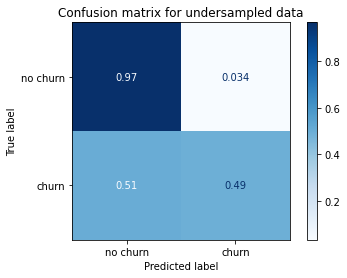

In [ ]:
plot_confusion_matrix(y_test,
                     xgb_pipeline.predict(X_test),
                     "Confusion matrix for undersampled data")

XGB accuracy score with SMOTE oversampled dataset: 0.8206666666666667



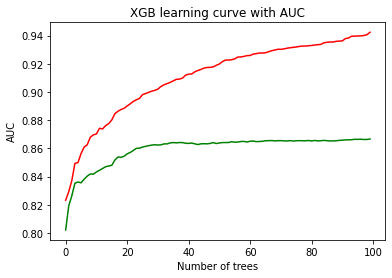

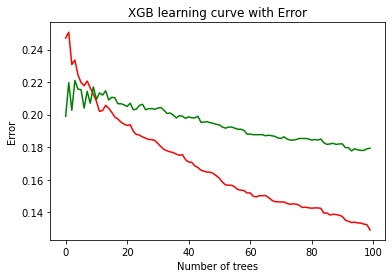

In [ ]:
# accessing XGBoost incremental performance as the number of trees increases
eval_set = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
eval_metric = ["auc", "error"]
xgb = XGBClassifier()
xgb.fit(X_train_resampled, 
        y_train_resampled, 
        eval_metric=eval_metric, 
        eval_set=eval_set, 
        verbose=False)
xgb_eval_results = xgb.evals_result()
# get evaluation results for train and test
xgb_train_eval = xgb_eval_results["validation_0"]
xgb_test_eval = xgb_eval_results["validation_1"]

# compute accuracy score
xgb_score = xgb.score(X_test, y_test)
print(f"XGB accuracy score with SMOTE oversampled dataset: {xgb_score}\n")

plot_learning_curve(
  train_results = xgb_train_eval["auc"],
  test_results = xgb_test_eval["auc"],
  x_label="Number of trees",
  y_label="AUC",
  title = "XGB learning curve with AUC"
)
plot_learning_curve(
  train_results = xgb_train_eval["error"],
  test_results = xgb_test_eval["error"],
  x_label="Number of trees",
  y_label="Error",
  title = "XGB learning curve with Error"
)

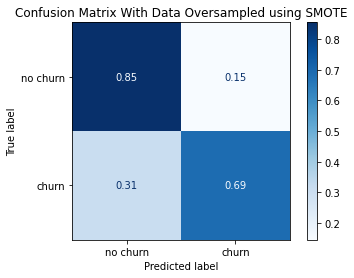

In [ ]:
# plot confusion matrix
y_pred = xgb.predict(X_test)
plot_confusion_matrix(y_test,
                      y_pred,
                      "Confusion Matrix With Data Oversampled using SMOTE")

In [ ]:
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################
xgb_params_space = {
    "learning_rate": np.linspace(0.1, 0.01, 100),
    "subsample": np.linspace(0.6, 1, 10),
    "colsample_bytree": np.linspace(0.8, 1, 10),
    "gamma": [0, 1, 5],
    "max_depth": [10, 20, 30, 40, 50],
    "n_estimators": np.linspace(20, 100, 80).astype(int)
}
xgb_rs = random_search_cv_optimization(X_train_resampled, 
                              y_train_resampled,
                              XGBClassifier(),
                              xgb_params_space,
                              n_iter=10,
                              scoring="f1")

xgb_rs.best_params_

{'subsample': 0.9555555555555555,
 'n_estimators': 69,
 'max_depth': 50,
 'learning_rate': 0.023636363636363636,
 'gamma': 1,
 'colsample_bytree': 0.9111111111111111}

In [ ]:
xgb_tuned = XGBClassifier(learning_rate=0.02, 
                          n_estimators=69, 
                          objective='binary:logistic', 
                          subsample=0.96, 
                          gamma=1, 
                          colsample_bytree=0.91, 
                          max_depth=50)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

XGBClassifier(colsample_bytree=0.91, gamma=1, learning_rate=0.02, max_depth=50,
              n_estimators=69, subsample=0.96)

In [ ]:
y_pred = xgb_tuned.predict(X_test)
xgb_tuned.score(X_test, y_test)

0.85

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2379
           1       0.64      0.62      0.63       621

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



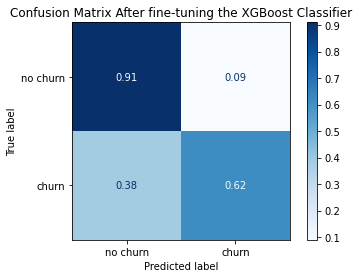

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix After fine-tuning the XGBoost Classifier")

## Explain XGBoost with Lime

In [ ]:
# index corresponding to the test vector
i = 10
# number denoting the top features
k = 7

xgb_exp_lime = explainer_lime.explain_instance(X_test[i],
                                           xgb_pipeline.predict_proba,
                                           num_features=k)
xgb_exp_lime.show_in_notebook()

Intercept 0.21075300926040758
Prediction_local [0.02542914]
Right: 0.027998345


## Explain XGBoost With SHAP

In [ ]:
shap_explainer_xgb = shap.TreeExplainer(xgb_tuned)
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)
shap_values_xgb

array([[ 0.02160281,  0.38049203,  0.06478224, ...,  0.00145602,
        -0.12773155,  0.02756808],
       [ 0.03409439, -0.1195363 ,  0.12435582, ..., -0.01408953,
         0.1580231 ,  0.14620556],
       [-0.0386595 , -0.30285525,  0.09116371, ..., -0.00327731,
        -0.35792473, -0.1110147 ],
       ...,
       [-0.05538611, -0.16469376, -0.15465765, ..., -0.02746471,
        -0.19446686, -0.09081024],
       [-0.06760454, -0.27109838, -0.09433068, ..., -0.00579664,
        -0.7004185 , -0.03878413],
       [-0.01194262,  0.22998463,  0.08134129, ..., -0.01781796,
        -0.18269533,  0.03091408]], dtype=float32)

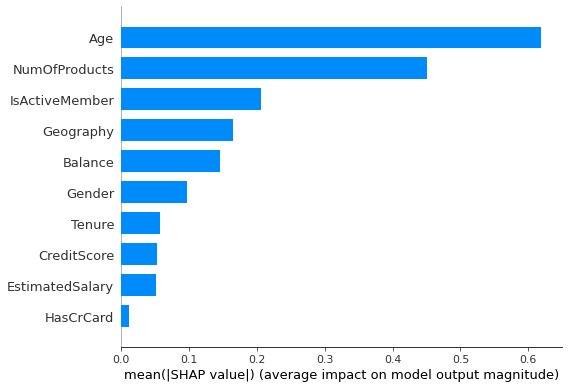

In [ ]:
shap.summary_plot(shap_values_xgb, X_df, plot_type='bar')

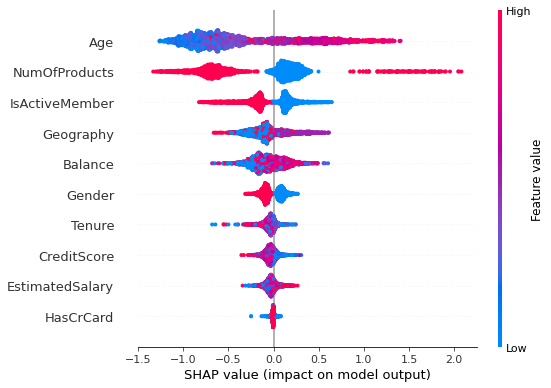

In [ ]:
shap.summary_plot(shap_values_xgb, X_df)

# Logistic Regression

In [ ]:
lr_pipeline = LogisticRegression()

lr_cv = RepeatedStratifiedKFold(n_splits=100, n_repeats=3, random_state=0)
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, scoring='accuracy', cv=lr_cv, n_jobs=-1)
lr_scores

array([0.82857143, 0.77142857, 0.78571429, 0.82857143, 0.8       ,
       0.82857143, 0.78571429, 0.77142857, 0.78571429, 0.81428571,
       0.74285714, 0.85714286, 0.75714286, 0.78571429, 0.81428571,
       0.77142857, 0.82857143, 0.78571429, 0.78571429, 0.87142857,
       0.8       , 0.81428571, 0.8       , 0.81428571, 0.84285714,
       0.78571429, 0.8       , 0.82857143, 0.77142857, 0.82857143,
       0.82857143, 0.8       , 0.82857143, 0.81428571, 0.82857143,
       0.77142857, 0.84285714, 0.75714286, 0.78571429, 0.8       ,
       0.82857143, 0.78571429, 0.81428571, 0.8       , 0.74285714,
       0.8       , 0.78571429, 0.82857143, 0.84285714, 0.77142857,
       0.84285714, 0.8       , 0.75714286, 0.87142857, 0.75714286,
       0.8       , 0.75714286, 0.75714286, 0.82857143, 0.81428571,
       0.84285714, 0.84285714, 0.81428571, 0.82857143, 0.84285714,
       0.78571429, 0.81428571, 0.81428571, 0.81428571, 0.81428571,
       0.85714286, 0.81428571, 0.81428571, 0.82857143, 0.85714

In [ ]:
lr_pipeline.fit(X_train_resampled, y_train_resampled)
lr_pipeline.score(X_test, y_test)

0.7003333333333334

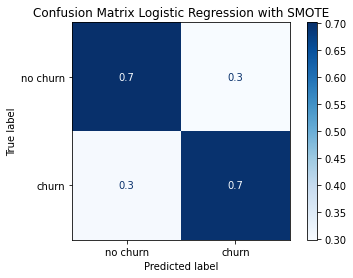

In [ ]:
# plot confusion matrix
y_pred = lr_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix Logistic Regression with SMOTE")

In [ ]:
# logistic regression parameter tunning using grid search

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

LR_params = {
              "tol": np.logspace(-0.1, 1e-6, num=100),
              "C": np.linspace(0, 1, 100),
              "penalty": ['l2', 'elasticnet', 'none'],
             "solver": ["newton-cg", "lbfgs", "sag", "saga"],
             "max_iter": np.linspace(100, 2000, 1000)
            }
lr_gs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      LogisticRegression(random_state=0),
                                      LR_params,
                                      n_iter=1000,
                                      scoring="f1"
                                      )
lr_gs.best_params_


3570 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
910 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

-------------------------

{'tol': 0.8840261484294427,
 'solver': 'saga',
 'penalty': 'l2',
 'max_iter': 1381.8818818818818,
 'C': 0.020202020202020204}

Accuracy score: 0.692


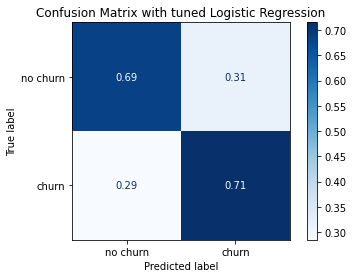

In [ ]:
lr_tuned = LogisticRegression(tol=0.88,
                              penalty='l2',
                              C=0.02, random_state=0,
                              solver="saga",
                              max_iter=1381)
lr_tuned.fit(X_train_resampled, y_train_resampled)
print(f"Accuracy score: {lr_tuned.score(X_test, y_test)}")
y_pred = lr_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned Logistic Regression")

In [ ]:
print(f"Logistic regression classification report \n {classification_report(y_test, y_pred)}")

Logistic regression classification report 
               precision    recall  f1-score   support

           0       0.90      0.69      0.78      2379
           1       0.37      0.71      0.49       621

    accuracy                           0.69      3000
   macro avg       0.64      0.70      0.63      3000
weighted avg       0.79      0.69      0.72      3000



In [ ]:

# index corresponding to the test vector
i = 10
# number denoting the top features
k = 7

lr_exp_lime = explainer_lime.explain_instance(X_test.to_numpy()[i],
                                           lr_pipeline.predict_proba,
                                           num_features=k)
lr_exp_lime.show_in_notebook()

Intercept 0.49507290068344656
Prediction_local [0.31477114]
Right: 0.31773526757800535


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


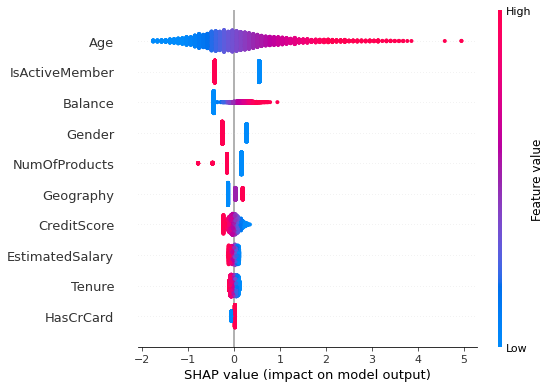

In [ ]:
lr_explainer = shap.Explainer(lr_tuned, X_train, feature_names=features)
lr_shap_values = lr_explainer(X_test)

shap.summary_plot(lr_shap_values, X_df)

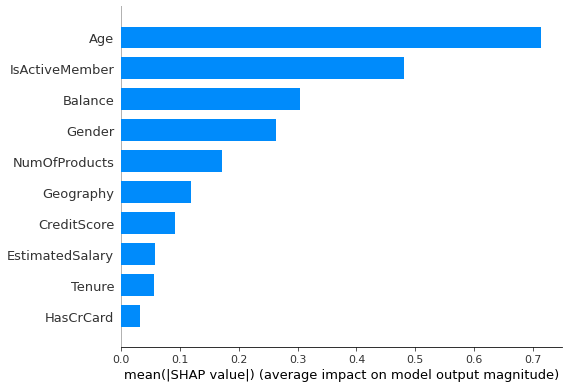

In [ ]:
shap.summary_plot(lr_shap_values, X_df, plot_type="bar")

# Random Forests

In [ ]:
RF_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
}

In [ ]:
rf_pipeline = RandomForestClassifier()
rf_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
rf_scores = cross_val_score(rf_pipeline,
                            X_train_resampled,
                            y_train_resampled,
                            scoring='f1',
                            cv=rf_cv,
                            n_jobs=-1)
rf_scores

array([0.91504425, 0.89464286, 0.91007194, 0.90535714, 0.91087344,
       0.91168599, 0.8959276 , 0.91726619, 0.92198582, 0.8981064 ,
       0.91021127, 0.90630631, 0.89928058, 0.89704566, 0.91689008,
       0.9005425 , 0.91561939, 0.89169675, 0.89759573, 0.9042077 ,
       0.90403587, 0.90334237, 0.91055456, 0.89642857, 0.90876242,
       0.90293856, 0.9197861 , 0.91681736, 0.9047195 , 0.89618456])

Accuracy score: 0.843


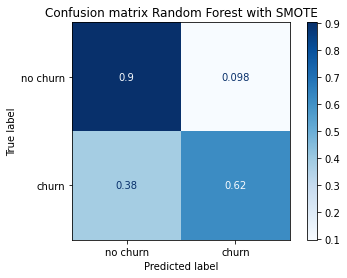

In [ ]:
rf_pipeline.fit(X_train_resampled, y_train_resampled)
rf_score = rf_pipeline.score(X_test, y_test)
print(f"Accuracy score: {rf_score}")
y_pred = rf_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion matrix Random Forest with SMOTE")

In [ ]:
# Random forest parameter tunning using grid search

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

rf_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      RandomForestClassifier(),
                                      RF_params,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
rf_rs.best_params_

{'n_estimators': 933,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_features': 3,
 'max_depth': 97,
 'bootstrap': False}

In [ ]:
rf_tuned = RandomForestClassifier(
    bootstrap=False,
    max_depth=97,
    max_features=3,
    min_samples_leaf=3,
    min_samples_split=12,
    n_estimators=933
)
rf_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, max_depth=97, max_features=3,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=933)

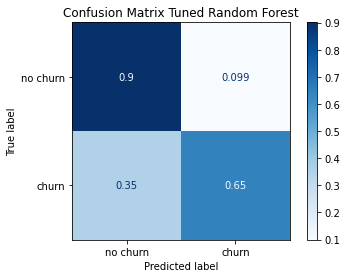

In [ ]:
# plot confusion matrix
y_pred = rf_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix Tuned Random Forest")

In [ ]:
rf_report = classification_report(y_test, y_pred)
print(f"Random Forest Classification Report: \n {rf_report}")

Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      2379
           1       0.63      0.65      0.64       621

    accuracy                           0.85      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.85      0.85      0.85      3000



## Explain Random Forest with SHAP

In [ ]:
shap_explainer_rf = shap.TreeExplainer(rf_tuned)
shap_values_rf = shap_explainer_rf.shap_values(X_test)
shap_values_rf

[array([[ 1.67946980e-03, -1.19891467e-01, -4.12646627e-02, ...,
         -5.01340512e-03,  2.07488302e-02,  3.68582568e-02],
        [ 7.52216712e-03,  9.85242100e-02, -4.90676433e-02, ...,
          1.73916551e-03, -4.83778333e-02,  4.81032390e-03],
        [ 1.87820687e-02,  9.43252688e-02, -3.19149854e-02, ...,
         -2.06822034e-03,  1.25215983e-01,  3.09837858e-02],
        ...,
        [ 9.41990438e-03,  7.41421708e-02,  4.07171582e-02, ...,
          6.90940518e-03,  5.05020062e-02,  1.62520752e-02],
        [ 1.99900964e-02,  7.89821306e-02,  3.63700021e-02, ...,
          2.54795647e-03,  1.63310720e-01,  1.89946719e-02],
        [-1.21406313e-04, -8.19641895e-02, -4.93487856e-02, ...,
          9.85104629e-03,  7.36615313e-02, -7.54740595e-03]]),
 array([[-1.67946980e-03,  1.19891467e-01,  4.12646627e-02, ...,
          5.01340512e-03, -2.07488302e-02, -3.68582568e-02],
        [-7.52216712e-03, -9.85242100e-02,  4.90676433e-02, ...,
         -1.73916551e-03,  4.83778333e

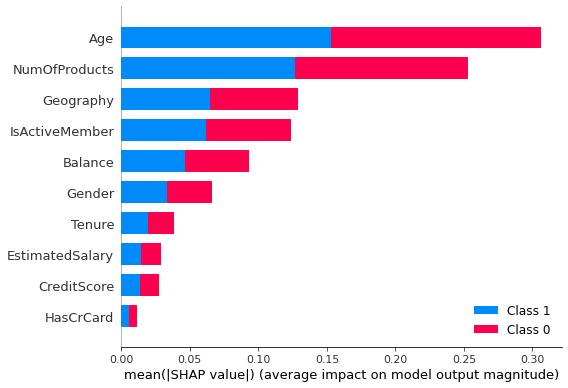

In [ ]:
shap.summary_plot(shap_values_rf, X_df)

In [ ]:
# shap.summary_plot(shap_values_rf, X_df, plot_kind="bar")

## Explain Random Forest with LIME

In [ ]:
# index corresponding to the test vector
i = 10
# number denoting the top features
k = 7

rf_exp_lime = explainer_lime.explain_instance(X_test[i],
                                           rf_tuned.predict_proba,
                                           num_features=k)
rf_exp_lime.show_in_notebook()

Intercept 0.20157491793172547
Prediction_local [0.03910101]
Right: 0.023603608491068295


# Support Vector Machines

In [13]:
svm_pipeline = SVC()
svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
svc_scores = cross_val_score(svm_pipeline,
                             X_train_resampled,
                             y_train_resampled,
                             scoring='accuracy',
                             cv=svc_cv,
                             n_jobs=-1)
svc_scores

array([0.8003581 , 0.81020591, 0.81468218, 0.82005372, 0.81826321,
       0.82542525, 0.82811101, 0.81378693, 0.82885305, 0.81003584,
       0.81647269, 0.84243509, 0.82452999, 0.80214861, 0.82900627,
       0.79230081, 0.82811101, 0.80572963, 0.81541219, 0.8046595 ,
       0.82273948, 0.82273948, 0.81289167, 0.81378693, 0.83348254,
       0.81647269, 0.81647269, 0.81915846, 0.81003584, 0.79659498])

In [14]:
svm_pipeline.fit(X_train_resampled, y_train_resampled)
svm_pipeline.score(X_test, y_test)

0.782

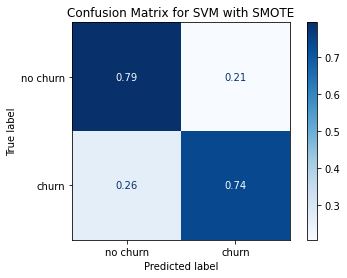

In [15]:
# plot confusion matrix
y_pred = svm_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for SVM with SMOTE")

In [ ]:
####################################################
####################################################
#                 DON'T RUN                        #
####################################################
####################################################
svm_param_grid = {'C': np.linspace(0.1, 100, 1000),
                  'gamma': ['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'decision_function_shape': ["ovo", "ovr"]}


svm_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      SVC(),
                                      svm_param_grid,
                                      n_iter=1,
                                      scoring="balanced_accuracy"
                                      )
svm_rs.best_params_

{'kernel': 'linear',
 'gamma': 'auto',
 'decision_function_shape': 'ovr',
 'C': 17.1}

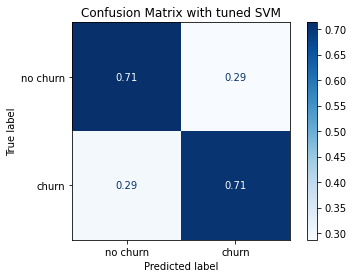

In [16]:
svm_tuned = SVC(kernel='linear',
                gamma='auto',
                decision_function_shape='ovr',
                C=17.1)
svm_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = svm_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned SVM")

In [17]:
print(f"SVM report \n {classification_report(y_test, y_pred)}")

SVM report 
               precision    recall  f1-score   support

           0       0.90      0.71      0.80      2379
           1       0.39      0.71      0.50       621

    accuracy                           0.71      3000
   macro avg       0.65      0.71      0.65      3000
weighted avg       0.80      0.71      0.74      3000



## Explain SVM with SHAP

In [25]:
svm_explainer = shap.Explainer(svm_tuned,
                               X_train_resampled,
                               feature_names=features)
svm_shap_values = svm_explainer(X_test)

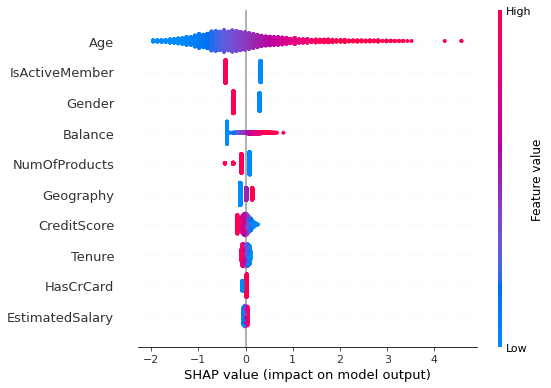

In [26]:
shap.summary_plot(svm_shap_values, X_df)

# Decision Tree

In [27]:
dt_pipeline = DecisionTreeClassifier()
dt_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
dt_scores = cross_val_score(dt_pipeline,
                            X_train_resampled,
                            y_train_resampled,
                            scoring='accuracy',
                            cv=dt_cv,
                            n_jobs=-1)
dt_scores

array([0.84064458, 0.82900627, 0.83706356, 0.84691137, 0.84243509,
       0.8603402 , 0.83795882, 0.83616831, 0.84408602, 0.8297491 ,
       0.83258729, 0.8603402 , 0.8263205 , 0.83706356, 0.8442256 ,
       0.81826321, 0.82990152, 0.84333035, 0.83064516, 0.82078853,
       0.83527305, 0.83348254, 0.84512086, 0.83348254, 0.82363474,
       0.83079678, 0.85138765, 0.8522829 , 0.83422939, 0.81541219])

In [28]:
dt_pipeline.fit(X_train_resampled, y_train_resampled)
dt_pipeline.score(X_test, y_test)

0.7846666666666666

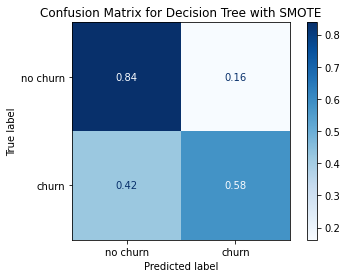

In [29]:
# plot confusion matrix
y_pred = dt_pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix for Decision Tree with SMOTE")

In [36]:
# decision tree hyper parameter optimisation

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

dt_params_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'splitter': ["best", "random"],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15]
    }

dt_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      DecisionTreeClassifier(),
                                      dt_params_grid,
                                      n_iter=100,
                                      scoring="roc_auc"
                                      )
dt_rs.best_params_



360 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

One or more of the test scores are non-finite: [       nan 0.88941976 0.82121065        nan        nan        nan
 0.88131697 0.88825855        nan 

{'splitter': 'best',
 'min_samples_split': 12,
 'min_samples_leaf': 9,
 'max_features': 7,
 'max_depth': 192,
 'criterion': 'entropy'}

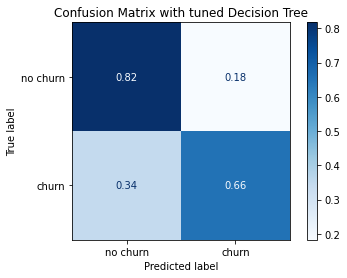

In [39]:
dt_tuned = DecisionTreeClassifier(
    splitter= 'best',
    min_samples_split= 12,
    min_samples_leaf= 9,
    max_features= 7,
    max_depth= 192,
    criterion= 'entropy'
)
dt_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = dt_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned Decision Tree")

In [41]:
print("Decision Tree Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Decision Tree Classification Report 

              precision    recall  f1-score   support

    no churn       0.90      0.82      0.86      2379
       churn       0.48      0.66      0.56       621

    accuracy                           0.78      3000
   macro avg       0.69      0.74      0.71      3000
weighted avg       0.81      0.78      0.79      3000



## Explain Decision Tree with SHAP

In [44]:
dt_explainer = shap.Explainer(dt_tuned.predict_proba, X_train_resampled)
dt_shap_values = dt_explainer(X_test)

Exact explainer: 3001it [01:17, 33.96it/s]                          


In [ ]:
shap.summary_plot(dt_shap_values, X_df)

# AdaBoost Classifier

In [45]:
ada_pipeline = AdaBoostClassifier()
ada_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
ada_scores = cross_val_score(ada_pipeline, X_train, y_train, scoring='accuracy', cv=ada_cv, n_jobs=-1)
ada_scores

array([0.85571429, 0.85714286, 0.85714286, 0.85      , 0.83      ,
       0.84571429, 0.84428571, 0.85571429, 0.83571429, 0.86428571,
       0.84285714, 0.85714286, 0.86      , 0.84428571, 0.85142857,
       0.84571429, 0.83857143, 0.86714286, 0.85      , 0.85428571,
       0.86142857, 0.85      , 0.85428571, 0.85428571, 0.85714286,
       0.84714286, 0.85142857, 0.83142857, 0.85571429, 0.84428571])

In [46]:
ada_pipeline.fit(X_train_resampled, y_train_resampled)
ada_pipeline.score(X_test, y_test)

0.7936666666666666

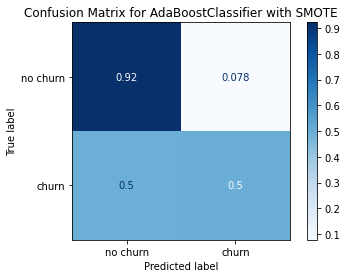

In [47]:
# plot confusion matrix
y_pred = ada_pipeline.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for AdaBoostClassifier with SMOTE")

In [52]:
# Adaboost Hyper Parameter Tuning
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

ada_params_grid = {
    'n_estimators': np.linspace(2, 20, 18).astype(int),
    'learning_rate': np.linspace(0.1, 0.01, 100),
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      AdaBoostClassifier(),
                                      ada_params_grid,
                                      n_iter=100,
                                      scoring="roc_auc"
                                      )
ada_rs.best_params_


{'n_estimators': 17,
 'learning_rate': 0.09727272727272727,
 'algorithm': 'SAMME.R'}

In [54]:
ada_tuned = AdaBoostClassifier(
    n_estimators=17,
    learning_rate=0.097,
    algorithm='SAMME.R'
)

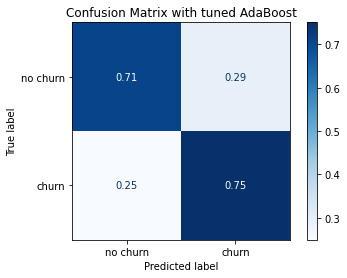

In [55]:
ada_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = ada_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned AdaBoost")

In [56]:
print("AdaBoost Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

AdaBoost Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.92      0.71      0.80      2379
       churn       0.40      0.75      0.53       621

    accuracy                           0.72      3000
   macro avg       0.66      0.73      0.66      3000
weighted avg       0.81      0.72      0.74      3000



## AdaBoost with SHAP

  0%|          | 0/3000 [00:00<?, ?it/s]

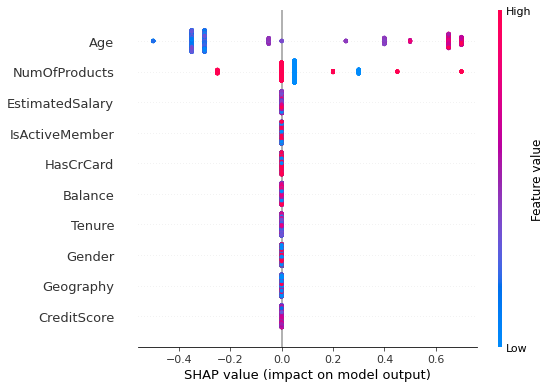

In [62]:
ada_explainer = shap.KernelExplainer(ada_tuned.predict, shap.sample(X_train, 10), feature_names=features)
ada_shap_values = ada_explainer.shap_values(X_test)

shap.summary_plot(ada_shap_values, X_df)

# Extra Trees Classifier

In [63]:
et_pipeline = ExtraTreesClassifier()
et_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
et_scores = cross_val_score(et_pipeline, X_train, y_train, scoring='accuracy', cv=et_cv, n_jobs=-1)
et_scores

array([0.85      , 0.83142857, 0.85714286, 0.86428571, 0.85285714,
       0.83142857, 0.86571429, 0.85428571, 0.82714286, 0.87285714,
       0.84      , 0.87428571, 0.86857143, 0.84714286, 0.83571429,
       0.85428571, 0.84571429, 0.87142857, 0.85428571, 0.84428571,
       0.86571429, 0.85      , 0.86714286, 0.85285714, 0.85571429,
       0.84285714, 0.86142857, 0.83857143, 0.86428571, 0.84428571])

In [64]:
et_pipeline.fit(X_train, y_train)
et_pipeline.score(X_test, y_test)

0.8636666666666667

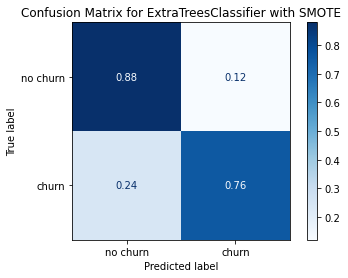

In [65]:
# plot confusion matrix
y_pred = et_pipeline.predict(X_test)
et_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for ExtraTreesClassifier with SMOTE")

In [68]:
# ExtraTrees Hyper Parameter Tuning
####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

et_params_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'bootstrap': [True, False],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
    }


et_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      ExtraTreesClassifier(),
                                      et_params_grid,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
et_rs.best_params_

{'n_estimators': 879,
 'min_samples_split': 13,
 'min_samples_leaf': 4,
 'max_features': 5,
 'max_depth': 85,
 'criterion': 'gini',
 'bootstrap': False}

In [69]:
et_tuned = ExtraTreesClassifier(
    criterion="gini",
    bootstrap=False,
    max_depth=85,
    max_features=5,
    min_samples_leaf=4,
    min_samples_split=13,
    n_estimators=879
)

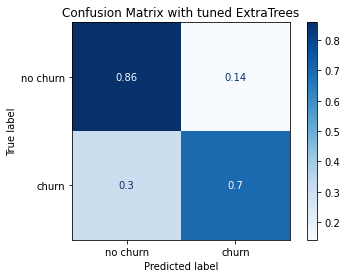

In [70]:
et_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = et_tuned.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Confusion Matrix with tuned ExtraTrees")

In [71]:
print("ExtraTrees Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

ExtraTrees Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.92      0.86      0.89      2379
       churn       0.56      0.70      0.62       621

    accuracy                           0.83      3000
   macro avg       0.74      0.78      0.75      3000
weighted avg       0.84      0.83      0.83      3000



In [72]:
# SHAP with ExtraTrees Classifier
shap_explainer_et = shap.TreeExplainer(et_tuned)
shap_values_et = shap_explainer_et.shap_values(X_test)
shap_values_et

[array([[-0.00425174, -0.12898902, -0.06428519, ..., -0.00353758,
          0.03994479,  0.00714884],
        [ 0.01294705,  0.09395485, -0.05225058, ..., -0.00301285,
         -0.07469024,  0.00624633],
        [ 0.01917474,  0.13947143, -0.05473702, ..., -0.00078127,
          0.15533511,  0.01336429],
        ...,
        [ 0.00857782,  0.0547994 ,  0.04918798, ...,  0.01247061,
          0.07575599,  0.03091601],
        [ 0.00859179,  0.08267962,  0.05709873, ...,  0.00690824,
          0.21176873,  0.00928649],
        [ 0.01257976, -0.09323942, -0.05531748, ...,  0.01489005,
          0.09343295, -0.00443938]]),
 array([[ 0.00425174,  0.12898902,  0.06428519, ...,  0.00353758,
         -0.03994479, -0.00714884],
        [-0.01294705, -0.09395485,  0.05225058, ...,  0.00301285,
          0.07469024, -0.00624633],
        [-0.01917474, -0.13947143,  0.05473702, ...,  0.00078127,
         -0.15533511, -0.01336429],
        ...,
        [-0.00857782, -0.0547994 , -0.04918798, ..., -

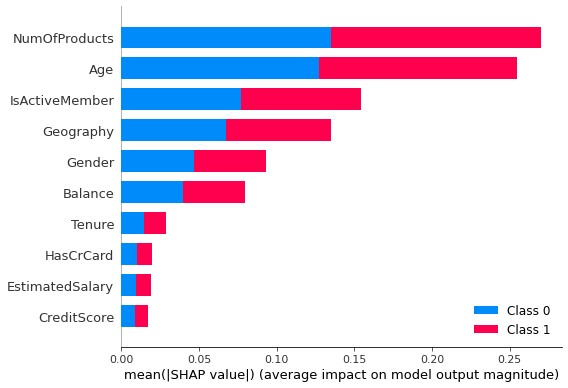

In [73]:
shap.summary_plot(shap_values_et, X_df)

# Gradient Boosting Classifier

In [75]:
gb_pipeline = GradientBoostingClassifier()

gb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
gb_scores = cross_val_score(gb_pipeline, X_train, y_train, scoring='accuracy', cv=gb_cv, n_jobs=-1)
gb_scores

array([0.86857143, 0.84714286, 0.86571429, 0.86142857, 0.86      ,
       0.85285714, 0.86285714, 0.85714286, 0.84714286, 0.88142857,
       0.86714286, 0.87142857, 0.87142857, 0.86142857, 0.85      ,
       0.84857143, 0.86285714, 0.87857143, 0.85714286, 0.86142857,
       0.87428571, 0.85714286, 0.86      , 0.86857143, 0.87142857,
       0.86857143, 0.86714286, 0.84428571, 0.86571429, 0.85285714])

In [76]:
gb_pipeline.fit(X_train, y_train)
gb_pipeline.score(X_test, y_test)

0.864

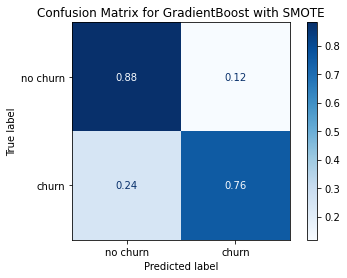

In [77]:
# plot confusion matrix
y_pred = gb_pipeline.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for GradientBoost with SMOTE")

In [79]:
# Gradient Boost Parameter Tuning


####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

gb_params_grid = {
    'loss': ['log_loss', 'deviance', 'exponential'],
    "learning_rate": np.linspace(0.1, 0.01, 100),
    'criterion': ["friedman_mse", "squared_error"],
    'max_depth': np.linspace(70, 200, 200).astype(int),
    'max_features': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'min_samples_split': [8, 10, 11, 12, 13, 14, 15],
    'n_estimators': np.linspace(100, 1000, 900).astype(int)
    }


gb_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      GradientBoostingClassifier(),
                                      gb_params_grid,
                                      n_iter=10,
                                      scoring="roc_auc"
                                      )
gb_rs.best_params_


10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not supported. 

One or more of the test scores are non-finite: [0.97188906 0.97102619        nan 0.9738

{'n_estimators': 495,
 'min_samples_split': 13,
 'min_samples_leaf': 7,
 'max_features': 3,
 'max_depth': 186,
 'loss': 'exponential',
 'learning_rate': 0.04818181818181818,
 'criterion': 'squared_error'}

In [12]:
gb_tuned = GradientBoostingClassifier(
    loss='exponential',
    learning_rate=0.05,
    criterion='squared_error',
    max_depth=186,
    max_features=3,
    min_samples_leaf=7,
    min_samples_split=13,
    n_estimators=495
)

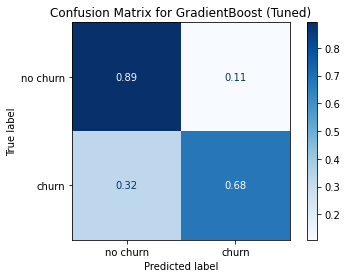

In [14]:
gb_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = gb_tuned.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for GradientBoost (Tuned)")

In [15]:
print("Gradient Boosting Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Gradient Boosting Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.89      0.93      0.91      2379
       churn       0.68      0.57      0.62       621

    accuracy                           0.85      3000
   macro avg       0.78      0.75      0.76      3000
weighted avg       0.85      0.85      0.85      3000



# KNeighbours Classifier

In [16]:
kn_pipeline = KNeighborsClassifier()
kn_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
kn_scores = cross_val_score(kn_pipeline, X_train, y_train, scoring='accuracy', cv=kn_cv, n_jobs=-1)
kn_scores

array([0.81285714, 0.83      , 0.82428571, 0.83142857, 0.82714286,
       0.81      , 0.82714286, 0.82      , 0.83714286, 0.84714286,
       0.81      , 0.83285714, 0.83857143, 0.82285714, 0.81714286,
       0.82285714, 0.81285714, 0.85428571, 0.83714286, 0.82857143,
       0.84285714, 0.82285714, 0.82      , 0.82142857, 0.84285714,
       0.82142857, 0.84428571, 0.82285714, 0.83142857, 0.82285714])

In [17]:
kn_pipeline.fit(X_train, y_train)
kn_pipeline.score(X_test, y_test)

0.8353333333333334

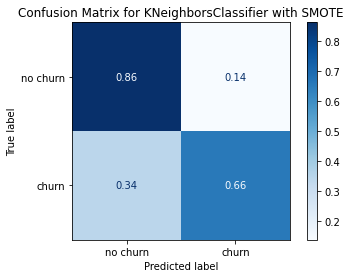

In [18]:
y_pred = kn_pipeline.predict(X_test)
kn_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for KNeighborsClassifier with SMOTE")

In [29]:
# KNeighbors Parameter Optimization

####################################################
####################################################
#                 DON'T RUN
####################################################
####################################################

knn_params_grid = {
    'n_neighbors': np.linspace(3, 10, 7).astype(int),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.linspace(30, 100, 7).astype(int),
    'p': [1, 2]
    }


knn_rs = random_search_cv_optimization(X_train_resampled,
                                      y_train_resampled,
                                      KNeighborsClassifier(),
                                      knn_params_grid,
                                      n_iter=10,
                                      scoring="balanced_accuracy"
                                      )
knn_rs.best_params_

{'weights': 'distance',
 'p': 1,
 'n_neighbors': 3,
 'leaf_size': 65,
 'algorithm': 'auto'}

In [30]:
knn_tuned = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance',
    algorithm='auto',
    leaf_size=65,
    p=1
)

In [31]:
knn_tuned.fit(X_train_resampled, y_train_resampled)
y_pred = knn_tuned.predict(X_test)

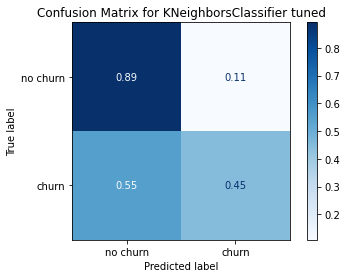

In [32]:
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for KNeighborsClassifier tuned")

In [33]:
print("KNeighbors Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

KNeighbors Classification Report 

              precision    recall  f1-score   support

    no churn       0.89      0.80      0.84      2379
       churn       0.45      0.63      0.53       621

    accuracy                           0.76      3000
   macro avg       0.67      0.71      0.68      3000
weighted avg       0.80      0.76      0.78      3000



# Voting Classifier

In [34]:
clf1 = RandomForestClassifier()
clf2 = ExtraTreesClassifier()
clf3 = GradientBoostingClassifier()
clf4 = SVC()
clf5 = DecisionTreeClassifier()
estimators = [('rf', clf1),
              ('et', clf2), 
              ('gb', clf3), 
              ('svm', clf4), 
              ('dt', clf5)
             ]

v_pipeline = VotingClassifier(estimators=estimators)
v_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
v_scores = cross_val_score(v_pipeline,
                           X_train_resampled,
                           y_train_resampled,
                           scoring='accuracy',
                           cv=v_cv,
                           n_jobs=-1)
v_scores

array([0.90152193, 0.8961504 , 0.89794091, 0.90599821, 0.90510295,
       0.89704566, 0.90241719, 0.91316025, 0.90322581, 0.890681  ,
       0.88988362, 0.89794091, 0.9042077 , 0.88182632, 0.91047449,
       0.88451209, 0.91763653, 0.88898836, 0.90681004, 0.90501792,
       0.90331244, 0.90689346, 0.90778872, 0.88272158, 0.90957923,
       0.89435989, 0.91136974, 0.91047449, 0.90412186, 0.8781362 ])

In [35]:
v_pipeline.fit(X_train_resampled, y_train_resampled)
v_pipeline.score(X_test, y_test)

0.8366666666666667

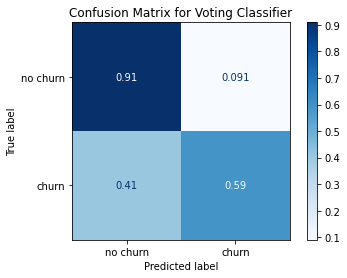

In [43]:
y_pred = v_pipeline.predict(X_test)
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for Voting Classifier")

In [37]:
print("Voting Ensemble Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

Voting Ensemble Classification Report 

              precision    recall  f1-score   support

    no churn       0.91      0.88      0.90      2379
       churn       0.59      0.66      0.63       621

    accuracy                           0.84      3000
   macro avg       0.75      0.77      0.76      3000
weighted avg       0.84      0.84      0.84      3000



# Extreme Learning Machine

In [47]:
from scipy.linalg import pinv2

INPUT_SIZE = X_train_resampled.shape[1]
HIDDEN_SIZE = 2000

input_weights = np.random.normal(size=[INPUT_SIZE, HIDDEN_SIZE])
biases = np.random.normal(size=[HIDDEN_SIZE])

def relu(x):
  return np.maximum(x, 0, x)

def hidden_nodes(X):
  G = np.dot(X, input_weights)
  G = G + biases
  H = relu(G)
  return H

output_weights = np.dot(pinv2(hidden_nodes(X_train_resampled)), y_train_resampled)

scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


In [48]:
def predict(X):
  out = hidden_nodes(X)
  out = np.dot(out, output_weights)
  return out 

In [49]:
prediction = predict(X_test)
correct = 0
total = X_test.shape[0]

for i in range(total):
  predicted = 1 if prediction[i] > 0.5 else 0
  actual = list(y_test)[i]
  correct += 1 if predicted == actual else 0

accuracy = correct/total
print(f"Accuracy for {HIDDEN_SIZE} hidden nodes: {accuracy}")

Accuracy for 2000 hidden nodes: 0.7636666666666667


In [50]:
prediction.shape

(3000,)

In [51]:
y_pred = [1 if i > 0.5 else 0 for i in prediction]

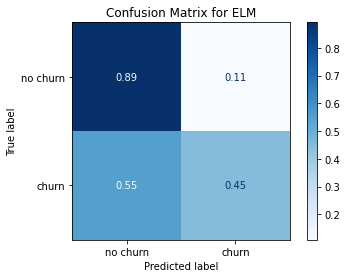

In [52]:
plot_confusion_matrix(y_pred,
                      y_test,
                      "Confusion Matrix for ELM")

In [53]:
print("ELM Classification Report \n")
print(classification_report(y_test, y_pred, target_names=["no churn", "churn"]))

ELM Classification Report 

              precision    recall  f1-score   support

    no churn       0.89      0.80      0.84      2379
       churn       0.45      0.63      0.52       621

    accuracy                           0.76      3000
   macro avg       0.67      0.71      0.68      3000
weighted avg       0.80      0.76      0.78      3000

